# Quantifying the impact

### Introduction

In this lesson, we'll take the feature variables that we deemed significant to our random forest model and begin to find the amount of impact that these feature variables have on the target variable.

### Load Data

Let's begin again by loading our data and training our random forest.

In [3]:
import pandas as pd
df_train = pd.read_feather('./train_removed_corr.feather')
df_val = pd.read_feather('./val_removed_corr.feather')

df_X_train = df_train.drop(columns = ['price'])
y_train = df_train.price

df_X_val = df_val.drop(columns = ['price'])
y_val = df_val.price

In [18]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=40, max_features='log2', random_state=0)
rfr.fit(df_X_train, y_train).score(df_X_val, y_val)

0.8221334962560631

### Working with a single tree

Now before interpreting our entire random forest, let's return to plotting just a single tree.  To do so, we'll select one of the trees from our random forest, and use our `plot_tree` method to plot our this tree.

In [33]:
first_tree = rfr.estimators_[0]

In [34]:
from sklearn import tree
from IPython.display import SVG, display
from graphviz import Source 


def plot_tree(dt, feature_names, max_depth):
    return Source(tree.export_graphviz(dt, out_file=None,
                                feature_names=feature_names, max_depth=max_depth))

Now let's plot our tree.

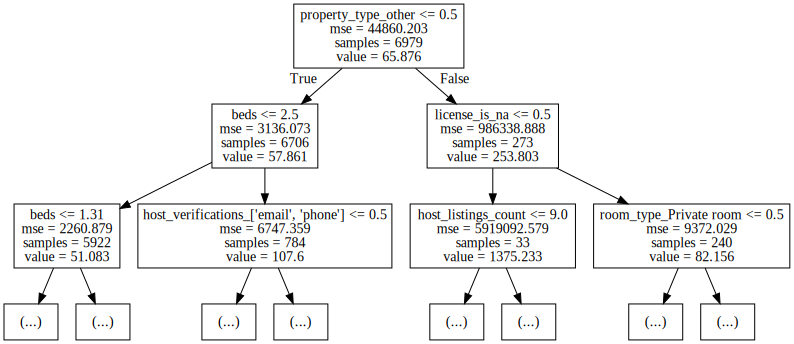

In [35]:
plot_tree(first_tree, df_X_train.columns, 2)

* Explaining a prediction with our tree 

Now let's try to explain the impact of each split on a specific observation.  In doing this we can begin to see how a feature is associated with the predicted target value.

How do we do this?  Well let's take a feature that would fall in the far left hand side of the tree.  Well this would be a feature that has zeros for the categorical features of `property_type_other`, `beds < 2.5`, and `beds < 1.31`.

We can see that the predicted value of the observation goes from $65.86$ to $57.86$ to $51.083$.

In [25]:
57.86 - 51.083

6.777000000000001

Now $65.86$ is the predicted value before there are any splits in the data.  It's effectively the average value of our data.

In [23]:
y_train.mean()

64.27466063348416

Then `property_type_other` $= 0$,  then $57.86$ is the predicted value, and when, in addition, $beds < = 2.5$, the predicted value is `51.08`.

$$y = \underset{\text{bias}}{65.87}-\underset{\text{prop_other=0}}{8.01}+\underset{\text{license_na=0}}{6.7}$$

So to determine the impact of each feature, we are just seeing how the predicted value changes as we move from node to node.

Which are the contribution values we get when we use `eli5`'s `explain_prediction_df` function.

In [44]:
first_obs = df_X_train.loc[0]

In [50]:
import eli5
explained_df_first_obs = eli5.explain_prediction_df(first_tree, first_obs)

selected = explained_df_first_obs.feature.isin(['beds', '<BIAS>', 'property_type_other'])
explained_df_first_obs[selected]

,target,feature,weight,value
0,y,<BIAS>,65.875747,1
7,y,property_type_other,-8.015018,0
9,y,beds,-12.331646,1


We can see that, other than beds, we calculated the same weight as `eli5`.  The discrepancy with beds is because there were multiple splits with beds, and we only counted the impact of the first split.

### Multiple Trees

Now that we understand how to calculate the feature weights of a single tree on an observation, let's see how to calculate the feature weights of an entire forest on an observation. 

To do so, we could simply take the average feature contributions from each tree.  Our `eli5.explain_prediction_df` function does this right out of the box.

In [51]:
explained_df_first_obs_rfr = eli5.explain_prediction_df(rfr, first_obs)
explained_df_first_obs_rfr

,target,feature,weight,value
0,y,<BIAS>,64.789520,1
1,y,room_type_Private room,18.509076,0
2,y,host_neighbourhood_is_na,0.600173,False
3,y,"host_verifications_['email', 'phone']",0.235061,0
4,y,summary_is_na,-0.635610,False
5,y,property_type_other,-2.548475,0
6,y,license_is_na,-2.967970,True
7,y,longitude,-3.295231,13.4112
8,y,host_listings_count,-4.890552,1
9,y,beds,-13.395992,1


Now of course, to really see the impact of a feature we don't want to just see the impact of our feature on just one row but on all of the rows.  Let's create an `explain_prediction_df` for each of our observations and combine them into one dataframe.

In [53]:
prediction_expls = []
for idx, row in df_X_val.iterrows():
    prediction_expls.append(eli5.explain_prediction_df(rfr, row))

In [54]:
train_expl_df = pd.concat(prediction_expls, keys=df_X_train.index, 
                         names=['observation'])

In [55]:
train_expl_df.value = train_expl_df.value.astype('float64')

In [91]:
train_expl_df.iloc[:5]

target                                feature     weight  \
observation                                                              
0           0      y                                 <BIAS>  64.789520   
            1      y                              longitude  12.410881   
            2      y  host_verifications_['email', 'phone']   0.303898   
            3      y               host_neighbourhood_is_na   0.032505   
            4      y                          summary_is_na  -0.837083   

                  value  
observation              
0           0   1.00000  
            1  13.45125  
            2   0.00000  
            3   1.00000  
            4   0.00000

We can view these a little more easily with the following code.

In [59]:
train_unstacked_df = (train_expl_df.groupby(['observation','feature'])
                               .weight
                               .aggregate('first')
                               .unstack())
train_unstacked_df.head()

feature,<BIAS>,beds,host_listings_count,host_neighbourhood_is_na,"host_verifications_['email', 'phone']",license_is_na,longitude,property_type_other,room_type_Private room,summary_is_na
observation,,,,,,,,,,
0,64.78952,-4.074720,-2.690094,0.032505,0.303898,-2.125719,12.410881,-2.022904,-14.761284,-0.837083
1,64.78952,-4.627469,-2.697016,0.450657,0.454173,-2.201487,1.364535,-2.106028,-15.679505,-0.747381
2,64.78952,-7.587953,17.176389,0.163445,-0.875984,-1.649555,-7.986650,-2.460608,-18.861773,-0.756830
3,64.78952,0.992858,-5.324342,1.440227,0.564052,-2.863535,-29.260585,-2.364928,18.070580,-1.068848
4,64.78952,-4.384787,-3.065386,0.108277,0.291906,-2.139840,-2.611325,-2.051640,-14.830400,-0.768824


In [68]:
train_unstacked_df.describe()[train_unstacked_df.describe().index.isin(['mean', 'std'])]

feature,<BIAS>,beds,host_listings_count,host_neighbourhood_is_na,"host_verifications_['email', 'phone']",license_is_na,longitude,property_type_other,room_type_Private room,summary_is_na
mean,6.478952e+01,0.372549,0.704862,0.515299,0.490458,0.319629,0.317161,-0.343127,0.228843,0.278540
std,4.846413e-12,30.916722,62.368293,20.745145,31.172217,21.518083,53.590868,13.403945,26.248046,23.603815


So the biggest thing to see is that the standard deviation is much larger than the mean.  In other words, for some observations, there is a large impact whereas for others, it does not matter.

### Back to plotting

In [ ]:
From here, we can plot the impact of 

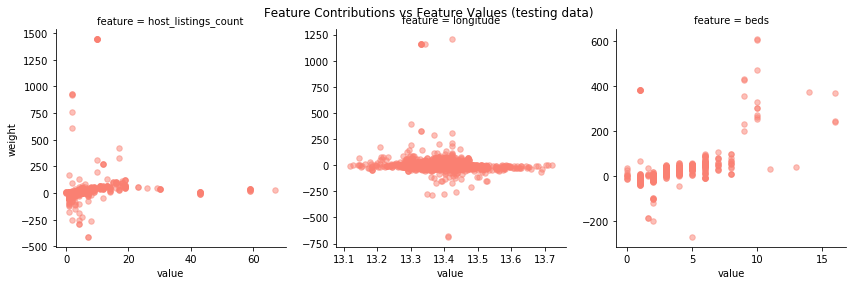

In [74]:
import seaborn as sns
fg = sns.lmplot(x='value', y='weight', col='feature',
                data=train_expl_df.loc[train_expl_df.feature.isin(['host_listings_count', 'longitude', 'beds'])], 
                col_order=['host_listings_count', 'longitude', 'beds'], sharex=False, sharey=False, col_wrap=3, fit_reg=False, 
                height=4, scatter_kws={'color':'salmon', 'alpha': 0.5, 's':30})


fg.fig.suptitle('Feature Contributions vs Feature Values (testing data)')
fg.fig.subplots_adjust(top=0.90);

With this, we can see that our model appears to reward host listings count from as it proceeds from zero to twenty.  And it appears to steadily increase the listing price for the number fo beds from 0 to 8.

## Joint Contributions

Now in the previous sections we tried to parse out how our features contributed to our predictions individually.  A different mechanism is to try to see discover the impact of interactions.  That is, what is the impact of two or more features occurring together.

To do this, we can use the `tree_interpreter` library with setting `joint_contribution = True`.

In [220]:
import treeinterpreter.treeinterpreter as ti
joint_pred, joint_bias, joint_contrib = ti.predict(rfr,
                                                   df_X_val,
                                                   joint_contribution=True)

Well `joint_contrib` is a list of dictionaries, with a separarate dictionary for each observation.

In [221]:
len(joint_contrib)

4736

Let's look at one of those dictionaries, by looking at the first few items of that dictionary.

In [222]:
list(joint_contrib[0].items())[:3]

[((2, 5, 6, 8), array([-0.6559863])),
 ((2, 6), array([-0.33205177])),
 ((0, 1, 2, 5, 6, 7, 8), array([-0.21955631]))]

The tuples to the left represent the nodes that impacted the prediction of the observation across all random forests.  And the array on the right is the weight of the feature.  Here, we can see that the nodes are represented by their sequence.  

So `(2, 6)` with value `.332`, means that the random forest estimates that our features at indices 2 and 6 (`beds` and `property_type_other`) decreases the predicted value by .332.

Just like we did for individual features, we can aggregate the interactions of features for each observation, to see which interactions have what type of impact.

In [93]:
import numpy as np
def create_dataframe(contrib):
    feature_interactions = pd.Series(list(contrib.keys()))
    values = list(contrib.values())
    feature_values = pd.Series([value[0] for value in values])
    stacked = np.column_stack((feature_interactions, feature_values))
    return pd.DataFrame(stacked, columns = ['features', 'values'])

In [112]:
contribs = [create_dataframe(contrib) for contrib in joint_contrib]

In [113]:
feature_interactions_df = pd.concat(contribs)

In [114]:
feature_interactions_df[:2]

,features,values
0,"(2, 5, 6, 8)",0.344334
1,"(2, 6)",-0.332052


In [115]:
feature_interactions_df.shape

(1520492, 2)

Now the dataframe is quite large.  It has the impact of every interaction that occurs in our random forest across every observation.  Now the whole goal is to interpret these interactions, and things get a pretty convoluted when we start discussing the impact of four different things occurring at once.  So let's limit our interactions to just two things happening at once.

In [135]:
feature_interactions_df.features[:3].apply(lambda x: len(x))

0    4
1    2
2    5
Name: features, dtype: int64

In [138]:
selected_interactions = feature_interactions_df[feature_interactions_df.features.apply(lambda x: len(x) < 3)]

In [140]:
selected_interactions[:4]

,features,values
1,"(2, 6)",-0.332052
4,"(6,)",-1.83213
13,"(0, 6)",-0.196248
16,"(5, 6)",-0.131898


Ok, now it's time to link some names to these features.

In [141]:
def feature_tup_names(feature):
    feature_indices = np.array(feature)
    feature_names = ' | '.join(list(df_X_train.columns[feature_indices]))
    return feature_names

In [142]:
selected_interactions.features = selected_interactions.features.apply(lambda feature: feature_tup_names(feature))

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [143]:
selected_interactions[:5]

,features,values
1,beds | property_type_other,-0.332052
4,property_type_other,-1.83213
13,host_listings_count | property_type_other,-0.196248
16,license_is_na | property_type_other,-0.131898
23,summary_is_na,-0.772631


Ok, now that we have formatted the data properly, it's time to aggregate the data to calculate the impact of some of these features, and interactions.

1. Feature Importance 

Let's start by feature importance.  A simple way to calculate feature importance is simply to add up the absolute value of all of the impacts of each interaction across all observations.

In [146]:
abs_imp_joint_contrib = (selected_interactions.groupby('features')
                                          .values
                                          .apply(lambda x: x.abs().sum())
                                           .sort_values(ascending=False))

In [153]:
joint_contrib_count = (selected_interactions.groupby('features')
                                          .values
                                          .apply(lambda x: x.abs().count())
                                           .sort_values(ascending=False))

In [154]:
joint_contrib_avg = (selected_interactions.groupby('features')
                                          .values
                                          .apply(lambda x: x.abs().mean())
                                           .sort_values(ascending=False))

In [164]:
df_contribs = pd.DataFrame.merge(joint_contrib_count, joint_contrib_avg, left_index=True, right_index=True)
df_contribs.columns = ['count', 'avg_weight']
df_contribs.loc[df_contribs.avg_weight.sort_values(ascending=False).index][:10]

,count,avg_weight
features,,
host_listings_count | host_neighbourhood_is_na,319,17.271525
"host_listings_count | host_verifications_['email', 'phone']",319,15.749728
summary_is_na | property_type_other,419,10.441001
"license_is_na | host_verifications_['email', 'phone']",763,8.781249
summary_is_na | license_is_na,1150,7.161200
longitude | summary_is_na,466,6.281099
host_neighbourhood_is_na | summary_is_na,466,5.199178
property_type_other,11050,3.508851
host_listings_count,11050,2.980000


In [178]:
combined_sum_na_and_prop_other = df_X_train.apply(lambda x: str(x['summary_is_na']) + str(x['property_type_other']), axis = 1)

In [184]:
df_sum_na_prop_other = pd.DataFrame(combined_sum_na_and_prop_other, columns = ['sum_na_prop_other'])
df_sum_na_prop_other.loc[:, 'price'] = y_train

In [188]:
dummied_sum_na_prop_other = pd.get_dummies(df_sum_na_prop_other)
dummied_sum_na_prop_other[:3]

,price,sum_na_prop_other_False0,sum_na_prop_other_False1,sum_na_prop_other_True0,sum_na_prop_other_True1
0,48.0,1,0,0,0
1,165.0,1,0,0,0
2,37.0,1,0,0,0


In [219]:
mean_prices = []
for col in dummied_sum_na_prop_other.columns:
    mean_price = dummied_sum_na_prop_other[dummied_sum_na_prop_other[col] == 1].price.mean()
    count = dummied_sum_na_prop_other[dummied_sum_na_prop_other[col] == 1].shape[0]
    mean_prices.append((mean_price, count))
mean_prices[1:]

[(58.43990596532471, 10209),
 (92.79733333333333, 375),
 (63.47867298578199, 422),
 (1182.6136363636363, 44)]

### Resources 

[video fast foward](https://www.youtube.com/watch?v=NxYCY8-Qfx0)